In [13]:
# Libraries

In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, 
                                     ReLU, Add, Dropout, LSTM, MultiHeadAttention, Reshape,Flatten)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, precision_recall_curve, classification_report, auc
)
import tensorflow as tf
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tf_explain.core.grad_cam import GradCAM
import json


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [15]:
# Data Loading and Preprocessing

In [2]:
# Paths for the directories
root_dir = r'D:\A\data\dataset44'
train_dir = os.path.join(root_dir, "train")  # Your training data directory
val_dir = os.path.join(root_dir, "val")  # Your validation data directory
test_dir = os.path.join(root_dir, "test")  # Your test data directory

# Center crop preprocessing
def preprocess_image(image):
    h, w, _ = image.shape
    center_x, center_y = w // 2, h // 2
    crop_size = min(center_x, center_y)  
    cropped_image = image[
        center_y - crop_size:center_y + crop_size,
        center_x - crop_size:center_x + crop_size
    ]
    resized_image = cv2.resize(cropped_image, (224, 224))
    normalized_image = resized_image / 255.0  
    return normalized_image
# Training data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9, 1.3],
    channel_shift_range=50.0,
    shear_range=0.4,
    rotation_range=240,
    preprocessing_function=preprocess_image,  # Apply center crop and normalization
)

# Validation and test data generators (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Only rescaling for validation and test data

# Training set generator (load from train_dir)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True  # Shuffle training data
)

# Validation set generator (load from val_dir, no augmentation)
validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Validation data should not be shuffled
)

# Test set generator (load from test_dir, no augmentation)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Test data should not be shuffled
)

print("Class indices mapping:", train_generator.class_indices)

Found 2929 images belonging to 4 classes.
Found 367 images belonging to 4 classes.
Found 366 images belonging to 4 classes.
Class indices mapping: {'0-No DR': 0, '1-Mild': 1, '2-Moderate': 2, '3-4-Severe': 3}


In [17]:
# Model Definition

In [3]:
from tensorflow.keras.applications import ResNet50

resnet_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

x = resnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

In [4]:
base_model=resnet_model
model = Model(inputs=base_model.input, outputs=output)

In [5]:
for layer in base_model.layers[-20:]: 
    layer.trainable = True

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [6]:

#7 Compile the model
model.compile(optimizer=Adam(learning_rate=0.0002),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
# Model Training
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5, 
                              patience=3,  
                              min_lr=0.00000002,
                              mode='min',
                              verbose=1 )

checkpoint = ModelCheckpoint('ResNet.h5',  
                             monitor='val_loss',
                             save_best_only=True, 
                             mode='min') 

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=8, 
                               mode='min',
                               restore_best_weights=True)

In [24]:
history = model.fit(
    # Adjust class weights as needed
    train_generator, 
    validation_data=validation_generator,
    steps_per_epoch = len(train_generator),
    validation_steps = len(validation_generator),
    epochs=150,  
    callbacks=[checkpoint, early_stopping, reduce_lr],
    workers=6,  
    max_queue_size=20
    
)

Epoch 1/150
92/92 [==============================] - 50s 467ms/step - loss: 0.6801 - accuracy: 0.7276 - val_loss: 1.5461 - val_accuracy: 0.4905 - lr: 2.0000e-04
Epoch 2/150
92/92 [==============================] - 39s 404ms/step - loss: 0.4968 - accuracy: 0.7931 - val_loss: 1.9242 - val_accuracy: 0.1090 - lr: 2.0000e-04
Epoch 3/150
92/92 [==============================] - 41s 420ms/step - loss: 0.4742 - accuracy: 0.8085 - val_loss: 1.2677 - val_accuracy: 0.4905 - lr: 2.0000e-04
Epoch 4/150
92/92 [==============================] - 40s 407ms/step - loss: 0.4411 - accuracy: 0.8126 - val_loss: 1.2085 - val_accuracy: 0.4905 - lr: 2.0000e-04
Epoch 5/150
92/92 [==============================] - 42s 433ms/step - loss: 0.4019 - accuracy: 0.8426 - val_loss: 1.2239 - val_accuracy: 0.4905 - lr: 2.0000e-04
Epoch 6/150
92/92 [==============================] - 42s 431ms/step - loss: 0.3950 - accuracy: 0.8447 - val_loss: 1.7192 - val_accuracy: 0.5123 - lr: 2.0000e-04
Epoch 7/150
92/92 [===============

In [25]:
# Model Evaluation

In [7]:
save_dir='plots-ResNet'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

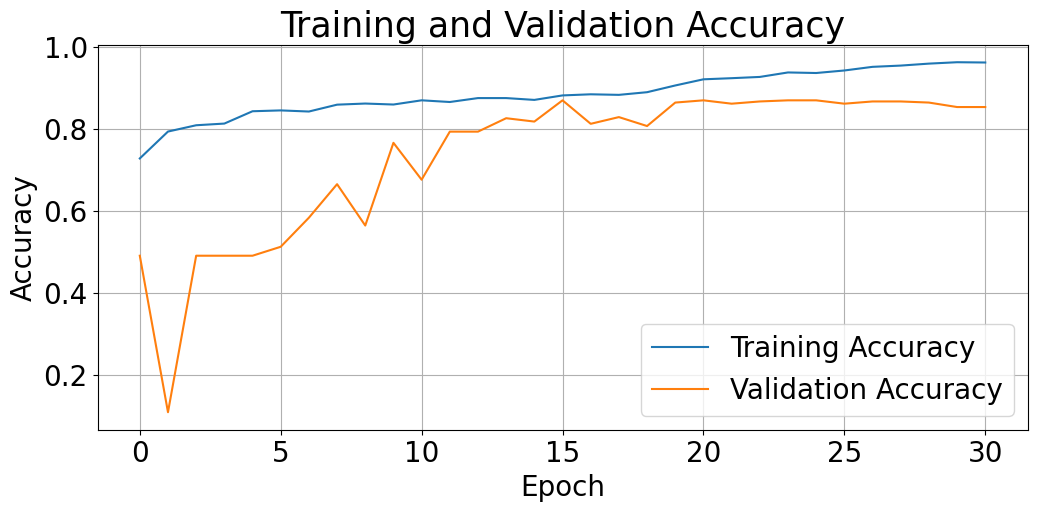

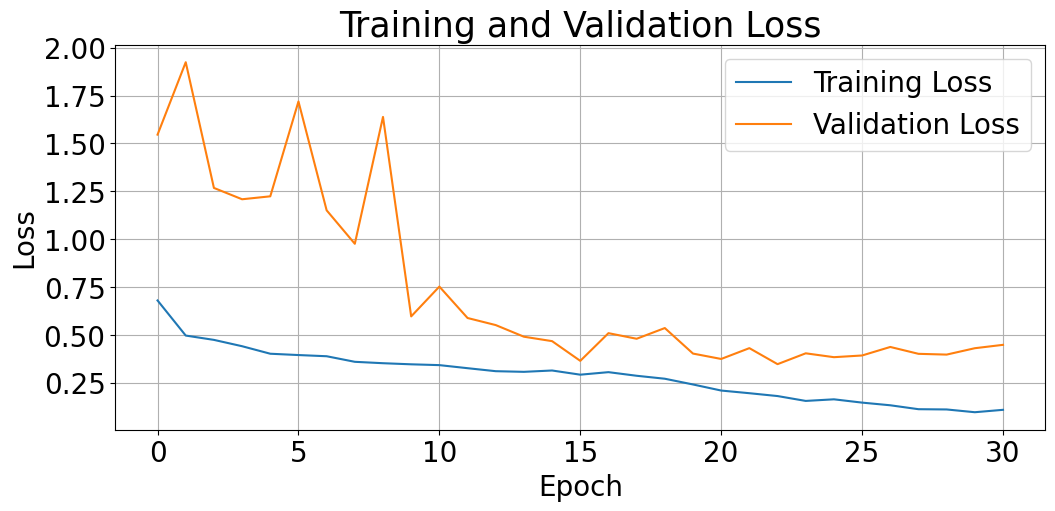

In [27]:
plt.figure(figsize=(12, 5))
# Accuracy curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=25)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'accuracy_plot.png'), dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 5))
# Loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=25)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'loss_plot.png'), dpi=600, bbox_inches='tight')
plt.show()

In [28]:
# Model Loading

In [8]:
model = load_model('ResNet.h5')

In [30]:
# Prediction and Inference

In [9]:
# Make predictions on the test data
predictions = model.predict(test_generator) 
true_labels = test_generator.classes 
class_labels = list(test_generator.class_indices.keys()) 
predicted_classes = np.argmax(predictions, axis=1)

12/12 [==============================] - 21s 2s/step


In [10]:
# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

def evaluate_model(true_labels, predicted_classes, class_labels, save_dir):
    # Ensure save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Micro average accuracy
    micro_accuracy = accuracy_score(true_labels, predicted_classes)
    
    # Generate classification report
    classification_report_dict = classification_report(
        true_labels, predicted_classes, target_names=class_labels, output_dict=True, zero_division=0
    )

    # Calculate specificity and accuracy per class
    specificity_per_class = []
    accuracy_per_class = []
    total_tn, total_fp = 0, 0  # For micro-average specificity
    for i in range(len(class_labels)):
        true_negative = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        false_positive = np.sum(cm[:, i]) - cm[i, i]
        specificity = true_negative / (true_negative + false_positive) if (true_negative + false_positive) > 0 else 0.0
        specificity_per_class.append(specificity)

        accuracy = cm[i, i] / np.sum(cm[i, :]) if np.sum(cm[i, :]) > 0 else 0.0
        accuracy_per_class.append(accuracy)

        total_tn += true_negative
        total_fp += false_positive

    # Calculate macro and micro average specificity
    macro_specificity = np.mean(specificity_per_class)
    micro_specificity = total_tn / (total_tn + total_fp) if (total_tn + total_fp) > 0 else 0.0

    # Save classification report as JSON
    json_save_path = os.path.join(save_dir, "classification_report.json")
    with open(json_save_path, "w") as f:
        json.dump(classification_report_dict, f, indent=4)
    print(f"Classification Report saved to {json_save_path}")

    # Print classification report
    print("Classification Report:")
    print(f"{'Class':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Specificity':<12} {'Accuracy':<12} {'Support':<12}")
    for idx, cls in enumerate(class_labels):
        metrics = classification_report_dict[cls]
        print(f"{cls:<20} {metrics['precision']:<12.2f} {metrics['recall']:<12.2f} {metrics['f1-score']:<12.2f} {specificity_per_class[idx]:<12.2f} {accuracy_per_class[idx]:<12.2f} {metrics['support']:<12}")

    # Calculate macro average accuracy
    macro_accuracy = np.mean(accuracy_per_class)

    # Print micro average accuracy
    print(f"\nMicro Average Accuracy: {micro_accuracy:.2f}")
    
    # Print macro average accuracy
    print(f"Macro Average Accuracy: {macro_accuracy:.2f}")

    # Macro and Micro average metrics
    macro_precision = precision_score(true_labels, predicted_classes, average='macro', zero_division=0)
    macro_recall = recall_score(true_labels, predicted_classes, average='macro', zero_division=0)
    macro_f1 = f1_score(true_labels, predicted_classes, average='macro', zero_division=0)

    micro_precision = precision_score(true_labels, predicted_classes, average='micro', zero_division=0)
    micro_recall = recall_score(true_labels, predicted_classes, average='micro', zero_division=0)
    micro_f1 = f1_score(true_labels, predicted_classes, average='micro', zero_division=0)

    print("\nMacro Average Metrics:")
    print(f"Precision: {macro_precision:.2f}, Recall: {macro_recall:.2f}, F1-Score: {macro_f1:.2f}, Specificity: {macro_specificity:.2f}")

    print("\nMicro Average Metrics:")
    print(f"Precision: {micro_precision:.2f}, Recall: {micro_recall:.2f}, F1-Score: {micro_f1:.2f}, Specificity: {micro_specificity:.2f}")

evaluate_model(true_labels, predicted_classes, class_labels, save_dir)


Classification Report saved to plots-ResNet\classification_report.json
Classification Report:
Class                Precision    Recall       F1-Score     Specificity  Accuracy     Support     
0-No DR              0.98         0.99         0.98         0.98         0.99         180.0       
1-Mild               0.88         0.55         0.68         0.99         0.55         40.0        
2-Moderate           0.77         0.81         0.79         0.91         0.81         101.0       
3-4-Severe           0.71         0.82         0.76         0.95         0.82         45.0        

Micro Average Accuracy: 0.87
Macro Average Accuracy: 0.79

Macro Average Metrics:
Precision: 0.83, Recall: 0.79, F1-Score: 0.80, Specificity: 0.96

Micro Average Metrics:
Precision: 0.87, Recall: 0.87, F1-Score: 0.87, Specificity: 0.96


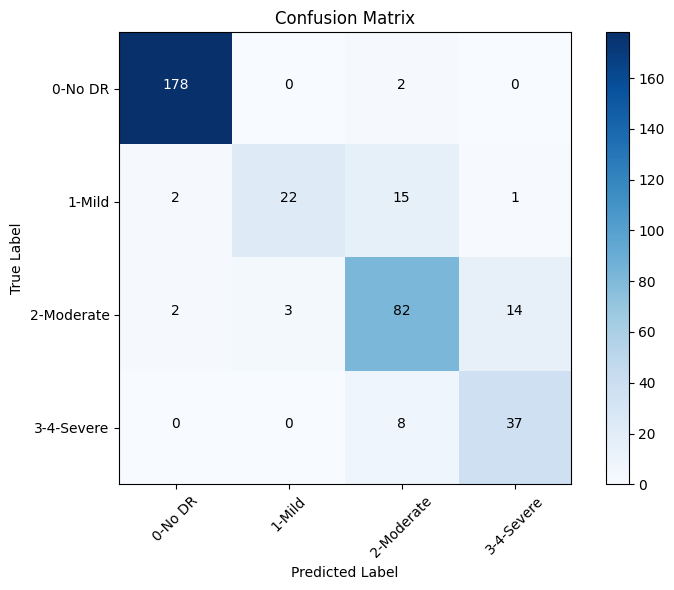

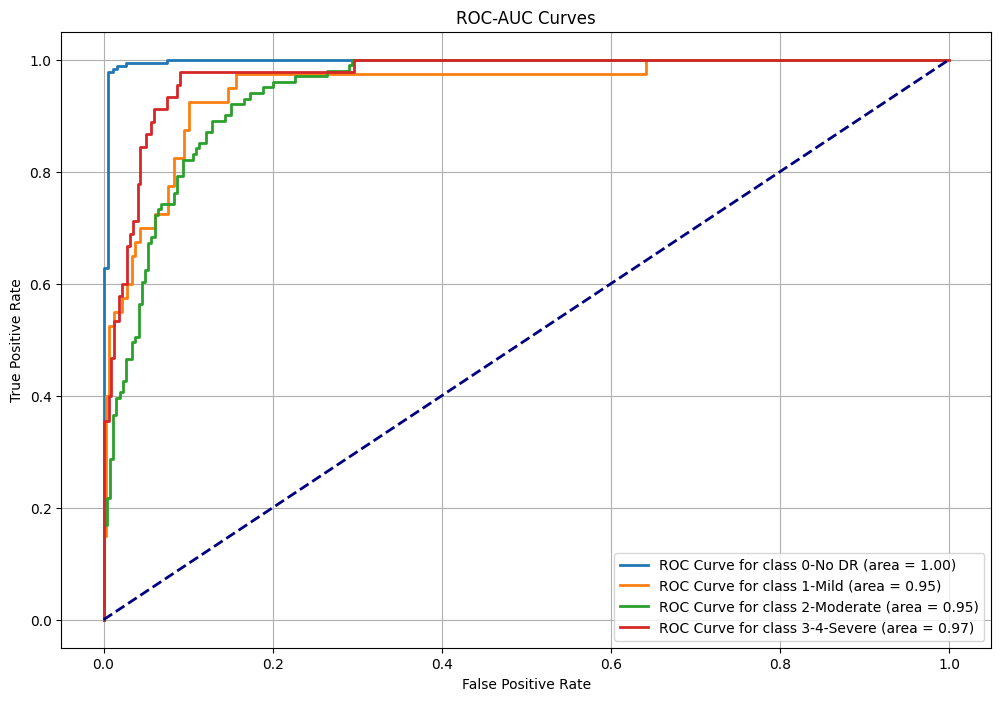

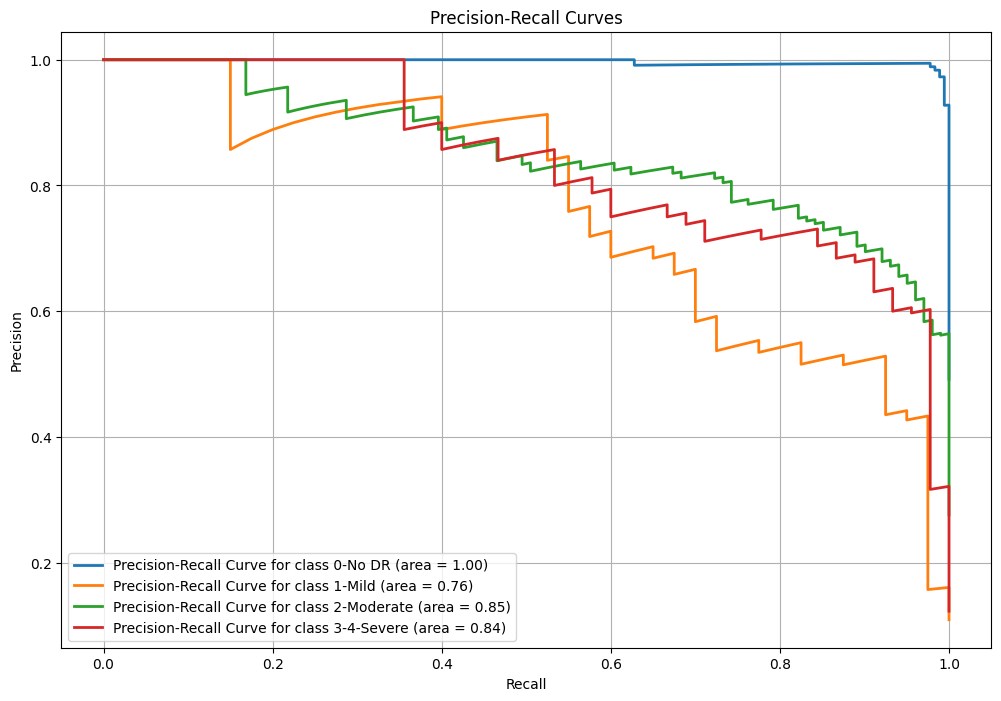

In [11]:

def plot_confusion_matrix(cm, class_labels, title='Confusion Matrix', cmap=plt.cm.Blues, save_dir=None):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    
    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f"{cm[i, j]}", horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    if save_dir:
        plt.savefig(f"{save_dir}/confusion_matrix.png", dpi=600, bbox_inches='tight')
    plt.show()

def plot_roc_auc_curves(true_labels, predictions, class_labels, save_dir):
    binarized_labels = tf.keras.utils.to_categorical(true_labels, num_classes=len(class_labels))
    plt.figure(figsize=(12, 8))
    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(binarized_labels[:, i], predictions[:, i])
        roc_auc = roc_auc_score(binarized_labels[:, i], predictions[:, i])
        plt.plot(fpr, tpr, lw=2, label=f'ROC Curve for class {class_labels[i]} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curves')
    plt.legend(loc='lower right')
    plt.grid(True)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.savefig(os.path.join(save_dir, 'roc_auc_curve.png'), dpi=600, bbox_inches='tight')
    plt.show()

def plot_precision_recall_curves(true_labels, predictions, class_labels, save_dir):
    binarized_labels = tf.keras.utils.to_categorical(true_labels, num_classes=len(class_labels))
    plt.figure(figsize=(12, 8))
    
    for i in range(len(class_labels)):
        precision, recall, _ = precision_recall_curve(binarized_labels[:, i], predictions[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, lw=2, label=f'Precision-Recall Curve for class {class_labels[i]} (area = {pr_auc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc='lower left')
    plt.grid(True)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    plt.savefig(os.path.join(save_dir, 'precision_recall_curve.png'), dpi=600, bbox_inches='tight')
    plt.show()

plot_confusion_matrix(cm, class_labels, title='Confusion Matrix', save_dir=save_dir)
plot_roc_auc_curves(true_labels, predictions, class_labels, save_dir)
plot_precision_recall_curves(true_labels, predictions, class_labels, save_dir)

In [34]:
import gc

K.clear_session()
gc.collect()

del model

In [35]:
from numba import cuda

cuda.select_device(0)
cuda.close()